# Sec Recon Network

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

from itertools import combinations
from utils import get_gene_color, flatten_processes, adjust_color_alpha

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="master_curated_09202021")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="Complexes")

In [3]:
secrecon

Index Flag      Initials   Edited GENE SYMBOL  \
0     44.0  NaN           NaN       HM     A3GALT2   
1     45.0  NaN           NaN       HM      A4GALT   
2     46.0  NaN           NaN       HM       A4GNT   
3     19.0  NaN           NaN  HM - PD        ABL1   
4     42.0  NaN           NaN       HM        ABL2   
..     ...  ...           ...      ...         ...   
910  743.0  NaN           NaN       JT        YOD1   
911    NaN  NaN           NaN       JT       USP19   
912    NaN  NaN           NaN      NaN         NaN   
913    NaN  NaN           NaN      NaN         NaN   
914    NaN  NaN  to be edited      100         NaN   

                                                 ALIAS          ENSEMBL  \
0                        A3GALT2P,IGB3S,IGBS3S,A3GALT2  ENSG00000184389   
1          A14GALT,A4GALT1,Gb3S,P(k),P1,P1PK,PK,A4GALT  ENSG00000128274   
2                                      alpha4GnT,A4GNT  ENSG00000118017   
3    ABL,BCR-ABL,CHDSKM,JTK7,bcr/abl,c-ABL,c-ABL1,p...  ENSG00000097007   
4                                        ABLL,ARG,ABL2  ENSG00000143322   
..                                                 ...              ...   
910                           DUBA8,OTUD2,PRO0907,YOD1  ENSG00000180667   
911                                                NaN              NaN   
912                                                NaN              NaN   
913                                                NaN              NaN   
914                                                NaN              NaN   

     ENTREZID                                           GENENAME  \
0    127550.0                  alpha 1,3-galactosyltransferase 2   
1     53947.0    alpha 1,4-galactosyltransferase (P blood group)   
2     51146.0          alpha-1,4-N-acetylglucosaminyltransferase   
3        25.0  ABL proto-oncogene 1, non-receptor tyrosine ki...   
4        27.0  ABL proto-oncogene 2, non-receptor tyrosine ki...   
..        ...                                                ...   
910   55432.0                                YOD1 deubiquitinase   
911       NaN                                                NaN   
912       NaN                                                NaN   
913       NaN                                                NaN   
914       NaN                                                NaN   

                                                  PMID  ... Process 10 Ref  \
0                           18630988,21873635,23378701  ...            NaN   
1    10591208,10747952,10748143,10854428,10993874,1...  ...            NaN   
2    10430883,11304796,12477932,12594234,15489334,1...  ...            NaN   
3    10187839,10194451,10212258,10372803,10391249,1...  ...            NaN   
4    10521789,10590083,10706884,10892742,11278261,1...  ...            NaN   
..                                                 ...  ...            ...   
910  12477932,14702039,16710414,19322201,19615732,1...  ...            NaN   
911                                                NaN  ...            NaN   
912                                                NaN  ...            NaN   
913                                                NaN  ...            NaN   
914                                                NaN  ...            NaN   

    Process 10 Genes Process 11  Process 11 Mean Score  Process 11 Score SD  \
0                NaN        NaN                    NaN                  NaN   
1                NaN        NaN                    NaN                  NaN   
2                NaN        NaN                    NaN                  NaN   
3                NaN        NaN                    NaN                  NaN   
4                NaN        NaN                    NaN                  NaN   
..               ...        ...                    ...                  ...   
910              NaN        NaN                    NaN                  NaN   
911              NaN        NaN                    NaN               

In [3]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['GENE SYMBOL']
    # Grab the processes and filter out any NaN values
    processes = row[['Process 1', 'Process 2', 'Process 3', 'Process 4', 'Process 5',
                     'Process 6', 'Process 7', 'Process 8', 'Process 9', 'Process 10']].dropna().tolist()
    gene_dict[gene] = {'processes': processes}
    
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})
    
#Complexes dict
complexes_dict = complexes.groupby('Gene')['Complex'].apply(list).to_dict()

In [4]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = complexes_dict.get(gene, 'Not part of any complex')

In [5]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

In [ ]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()], ax=ax)  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 30}) 

plt.savefig('gene_network.png', dpi=300, bbox_inches='tight')
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('int64'), dtype('<U9')) -> None

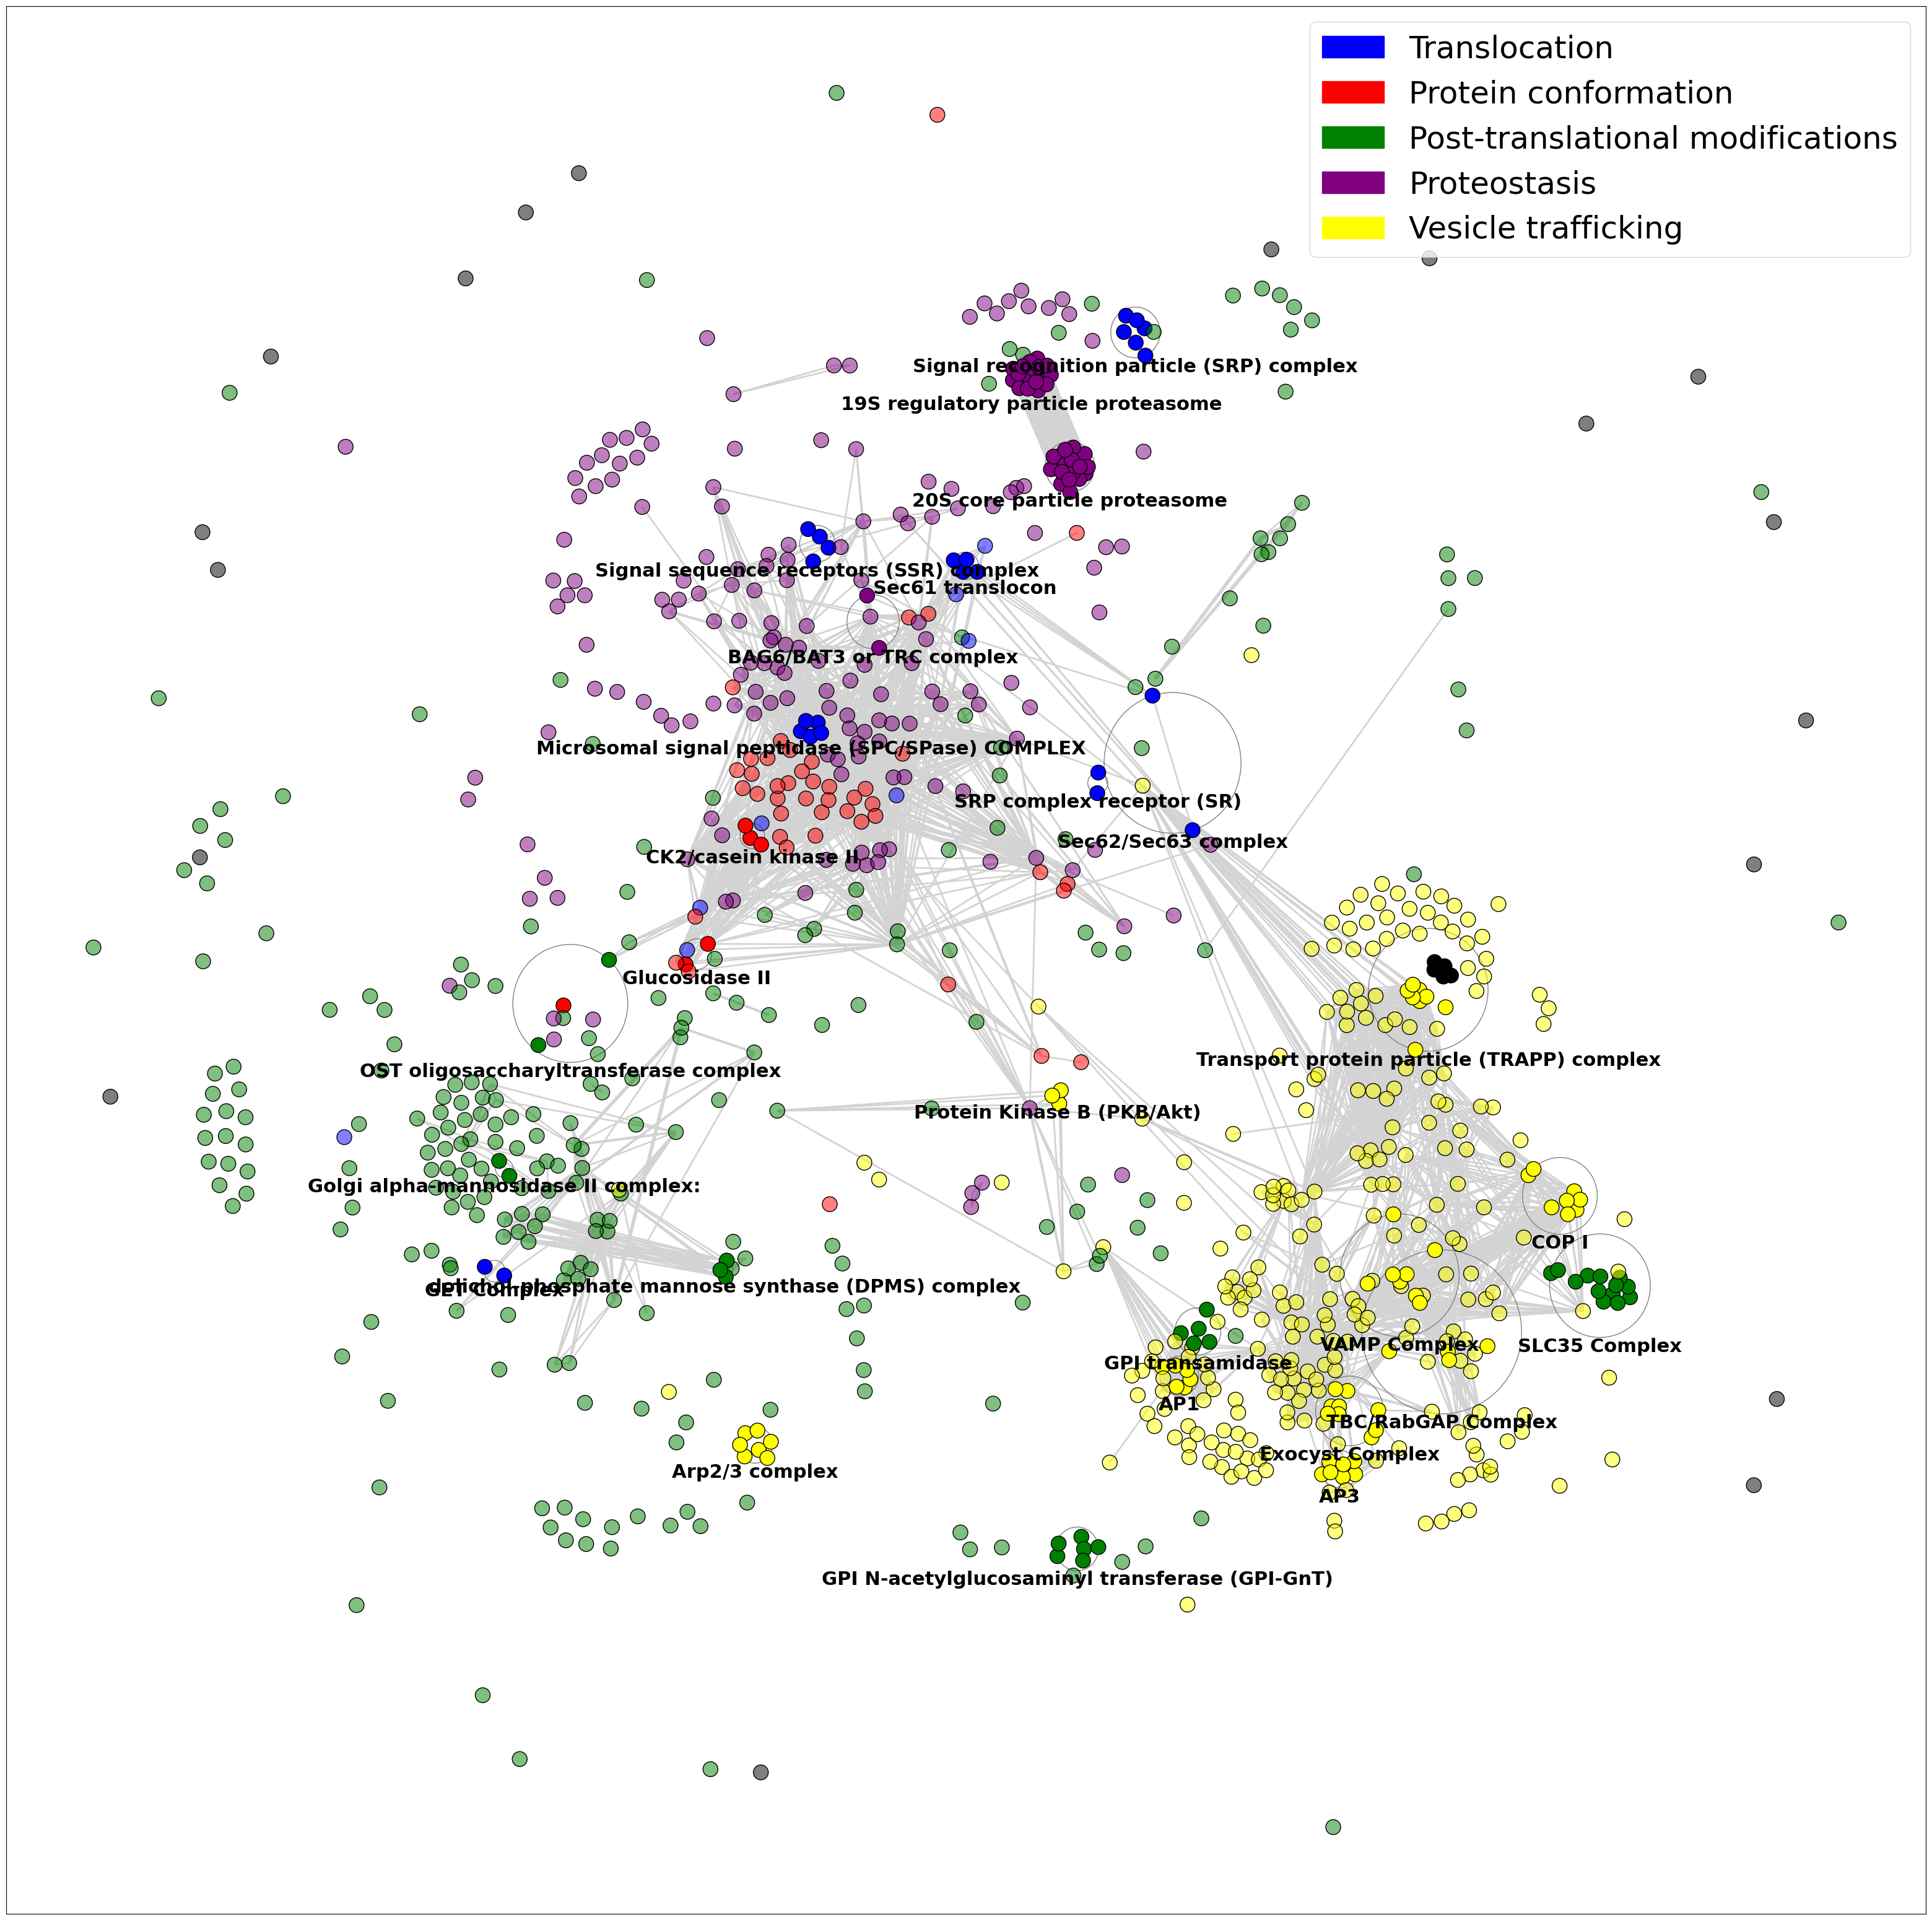

In [7]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
base_alpha = 0.5 # Set base transparency level
node_colors = [adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), 1.0) if gene_dict[node]['complex'] != 'Not part of any complex' else adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), base_alpha) for node in G.nodes]

# Adjust node sizes according to whether they are part of a complex
node_sizes = [300 if gene_dict[node]['complex'] != 'Not part of any complex' else 300 for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and max radius for each complex
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    avg_position = np.mean(positions, axis=0)
    max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
    complex_centers_radii[complex_] = (avg_position, max_radius)


# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='grey', lw=1)
    ax.add_patch(circle)
    label_y_position = center[1] - radius - 0.01
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.savefig('secrecon_network_complex.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
base_alpha = 0.5 # Set base transparency level
node_colors = [adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), 1.0) if gene_dict[node]['complex'] != 'Not part of any complex' else adjust_color_alpha(get_gene_color(node, gene_dict, process_dict, category_colors), base_alpha) for node in G.nodes]

# Adjust node sizes according to whether they are part of a complex
node_sizes = [300 if gene_dict[node]['complex'] != 'Not part of any complex' else 300 for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and convex hull for each complex
complex_centers_hulls = {}
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    if len(positions) > 2:  # Only compute convex hulls for complexes with more than 2 nodes
        hull = ConvexHull(positions)
        complex_centers_hulls[complex_] = hull
    else: #for those complexes that has 2 genes calculate the avg position to draw a circle
        avg_position = np.mean(positions, axis=0)
        max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
        complex_centers_radii[complex_] = (avg_position, max_radius)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 1])

# Draw the convex hulls for the complexes
for complex_, hull in complex_centers_hulls.items():
    # Draw the hull
    for simplex in hull.simplices:
        ax.plot(np.array(hull.points)[simplex, 0], np.array(hull.points)[simplex, 1], 'k-')
    # Draw the label
    center = np.mean(hull.points, axis=0)
    label_y_position = center[1] - 0.02
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')
    
# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='black', lw=1)
    ax.add_patch(circle)
    label_y_position = center[1] - radius - 0.01
    ax.text(center[0], label_y_position, complex_, horizontalalignment='center', verticalalignment='center', fontsize=22, weight='bold')

    
# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.savefig('secrecon_network_complex_2.png', dpi=300, bbox_inches='tight')
plt.show()